In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20250228-213124_continuous.json'

tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2025-08-03 17:48:45,251 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

#kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))
kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated_no_reg.yml"))

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [3]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 mmol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-6 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

In [4]:
# Load TFA samples 
import pandas as pd
import numpy as np
tfa_sample_file = 'reduced_model_ETC_core_20250228-213124_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)


faraday_const = 23.061 # kcal / mol / V
RT = tmodel.RT # kcal /mol
delta_psi_scaled = 150/1000 * faraday_const / RT  # mV * F / RT 

# Psuedo data for the membrane potential
tfa_samples['psi_m_c'] = delta_psi_scaled * 1e-3 # be aware of the scaling!!!
tfa_samples['MitoMembranePot_in'] = 1000 # ~ 1000 RT/min -> at 5 RT is equivalent to about 2 min time scale for the membrane potential
tfa_samples['MitoMembranePot_out'] = 1000

# 30 min timescale for insulin action 
tfa_samples['Insulin_secretion'] = 1/30 / flux_scaling_factor
tfa_samples['Insulin_degradation'] = 1/30 / flux_scaling_factor
tfa_samples['insulin_e'] = 1e-3 

additional_fluxes = ['MitoMembranePot_in','MitoMembranePot_out', 'Insulin_secretion', 'Insulin_degradation',]
additional_concentrations = ['psi_m_c', 'insulin_e']


<Axes: ylabel='Frequency'>

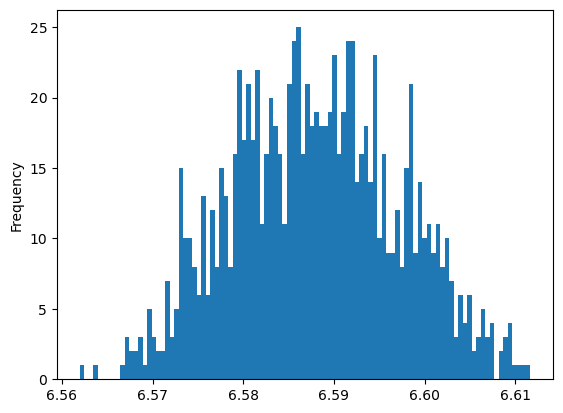

In [5]:
(tfa_samples['cyt_atp2adp'] * 1.2).plot.hist(bins=100) 

In [6]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
#parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters_no_reg.hdf5'))

In [7]:
# Prepare the model to run an ODE simulaiton
kmodel.compile_ode(ncpu=NCPU)

In [8]:
# Get stoichiometric matrix
from skimpy.utils.general import get_stoichiometry
S = get_stoichiometry(kmodel, kmodel.reactants).todense()


In [9]:
# Build function to compute fluxes from concentrations
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

In [10]:
from skimpy.core.parameters import ParameterValues
from skimpy.analysis.oracle import load_concentrations

from tqdm import tqdm

# Function for population analysis
def steady_state_perturbation(parameter, range=np.logspace(-1,1,51,base=10) , 
                            additional_parameter_changes={},
                            time = [0, 500], 
                            parameter_population=parameter_population, 
                            kmodel=kmodel, 
                            flux_function=flux_function,
                            tfa_samples=tfa_samples, 
                            end_ix=-1,
                            ):
    
    # List of dataframes
    results = []

    # Run the perturbation for each parameterset
    parameter_population_index = list(parameter_population._index.keys())
    
    for parameter_set_id in tqdm(parameter_population_index[:end_ix]):

        # This will be a list of dataframes
        this_results = []

        thermo_index = int(parameter_set_id.split(',')[0])
        thermo_sample = tfa_samples.loc[thermo_index]

        concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                            concentration_scaling=CONCENTRATION_SCALING,
                                            additional_concentrations=additional_concentrations)

        for k in kmodel.initial_conditions:
                kmodel.initial_conditions[k] = concentrations[k]

        # Load the parameter values 
        kmodel.parameters = parameter_population[parameter_set_id]

        # Integrate additional parameters changes (fold changes)
        for k, v in additional_parameter_changes.items():
            kmodel.parameters[k].value = kmodel.parameters[k].value * v

        # Perturb the main parameter
        if parameter == 'fuel':
            fuels = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e', ]
            p0 = [ kmodel.parameters[f].value for f in fuels]
        else:
            p0 = kmodel.parameters[parameter].value
        
        for perturbation_value in range:
            if parameter == 'fuel':
                for f, v in zip(fuels, p0):
                    kmodel.parameters[f].value = perturbation_value * v
            else:
                kmodel.parameters[parameter].value = perturbation_value * p0
            # Dynamic solution            
            sol = kmodel.solve_ode(time, solver_type='cvode' , max_steps=1e9, rtol=1e-6)
            # Get steady state concentrations
            steady_state_concentrations = sol.concentrations.iloc[-1]

            # Compute the fluxes at steady state
            # Get parameters value set 
            parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
            parameter_values = ParameterValues(parameter_values, kmodel)

            steady_state_fluxes = pd.Series(flux_function(steady_state_concentrations, parameters=parameter_values), 
                                            index=kmodel.reactions.keys())
            
            # Check if fluxes are approximetly at  steady state
            dxdt = S @ steady_state_fluxes[kmodel.reactions.keys()]
            is_steady_state = np.all(abs(dxdt) < 1e-3*flux_scaling_factor)

            # if not is_steady_state:
            #     print('Warning: Not steady state')
            #     # Print the concentrations that are not at steady state
            #     # Get indexes from the model 
            #     non_steady_state_ix = np.where(abs(dxdt) >= 1e-3*flux_scaling_factor)[0]
            #     concentrations_not_steady_state =[ kmodel.reactants.iloc(i)[0] for i in non_steady_state_ix]
            #     print(f'Concentrations not at steady state: {concentrations_not_steady_state}')
            #     # Print maximal dxdt value
            #     print(f'Max dxdt value: {np.max(abs(dxdt))}')
                
            #     #1/0 # Uncomment to debug
     

            # Add the results to a dataframe 
            steady_state_output = pd.concat([steady_state_concentrations, steady_state_fluxes])


            # Add metadata 
            steady_state_output['pertubration'] = perturbation_value
            steady_state_output['parameter_set'] = parameter_set_id
            steady_state_output['parameter'] = parameter    
            steady_state_output['aditional_parameters'] = [f'{k}:{v:.1f}' for k,v in additional_parameter_changes.items()]
            steady_state_output['is_steady_state'] = is_steady_state
            steady_state_output['tmax'] = time[-1]

            this_results.append(steady_state_output)

        # Concatenate the results
        this_results = pd.concat(this_results, axis=1).T

        results.append(this_results)
    
    # Concatenate the results
    results = pd.concat(results)

    return results


In [11]:
# Get the model name
name = model_file.replace('.json', '')

In [12]:
# # All fuels 
# results_2 = steady_state_perturbation('fuel', range=np.array([0.1, 1.0,10])) 
# results_2.to_csv(f'output/{name}_steady_state_robustness_all_fuels_10_fold.csv')


In [13]:
# Check fuel perutbations 

parameters = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e', ]
results = [steady_state_perturbation(p, range=np.array([0.1,1.0,10.0])) for p in parameters]
results = pd.concat(results)

# Save the results
#results.to_csv(f'output/{name}_steady_state_robustness_each_fuel_10_fold.csv')
results.to_csv(f'output/{name}_steady_state_robustness_each_fuel_10_fold_no_reg.csv')


  1%|          | 75/9502 [00:18<34:16,  4.58it/s]
[CVODE ERROR]  CVode
  At t = 75.7069 and h = 1.73402e-07, the error test failed repeatedly or with |h| = hmin.

  2%|▏         | 235/9502 [00:53<36:24,  4.24it/s]
[CVODE ERROR]  CVode
  At t = 150.521 and h = 1.06301e-07, the error test failed repeatedly or with |h| = hmin.

  3%|▎         | 244/9502 [00:54<33:15,  4.64it/s]
[CVODE ERROR]  CVode
  At t = 103.088 and h = 1.70613e-07, the error test failed repeatedly or with |h| = hmin.

  6%|▌         | 559/9502 [02:01<35:22,  4.21it/s]
[CVODE ERROR]  CVode
  At t = 109.239 and h = 4.3757e-07, the error test failed repeatedly or with |h| = hmin.

 10%|▉         | 911/9502 [03:15<25:10,  5.69it/s]
[CVODE ERROR]  CVode
  At t = 101.298 and h = 1.7323e-07, the error test failed repeatedly or with |h| = hmin.

 10%|█         | 981/9502 [03:31<33:20,  4.26it/s]
[CVODE ERROR]  CVode
  At t = 106.219 and h = 7.65815e-07, the error test failed repeatedly or with |h| = hmin.

 10%|█         | 98

In [14]:
# Todo: filter the patameters based on weather the non linear result reached steady state
robust_parameters = results.groupby('parameter_set')['is_steady_state'].sum()[results.groupby('parameter_set')['is_steady_state'].sum() >= 12].index

In [17]:
# Filter parameter sets for robustness in cyt_atp2adp
# Compute variability of cyt_atp2adp across perturbations for current robust_parameters
tolerance = 0.1  # maximum allowed variation in cyt_atp2adp
variability = results[results['parameter_set'].isin(robust_parameters)]\
    .groupby('parameter_set')['cyt_atp2adp']\
    .agg(lambda x: x.max() - x.min())
# Select parameter sets within tolerance
robust_cyt_sets = variability[variability < tolerance].index
# Update robust_parameters to include only those robust in cyt_atp2adp
robust_parameters = robust_parameters.intersection(robust_cyt_sets)

In [18]:
from skimpy.core.parameters import ParameterValuePopulation
# Save the robust parameters
robust_parameter_population = ParameterValuePopulation([parameter_population[ix] for ix in robust_parameters], kmodel, robust_parameters, )
#robust_parameter_population.save(tfa_sample_file.replace(".csv",'_robust_parameters.hdf5'))
robust_parameter_population.save(tfa_sample_file.replace(".csv",'_robust_parameters_no_reg.hdf5'))

In [19]:
# Filter the results 
results_filtered = results[results['parameter_set'].isin(robust_parameters)].reset_index()

In [20]:
len(robust_parameters)

111